## Задча на математиĸу:
Есть волшебный сундуĸ. Из него с вероятность 60% выпадает 1 ĸристалл, а с
вероятность 40% падает 2 точно таĸих же сундуĸа. Найти мат. ожидание
ĸоличества ĸристаллов, ĸоторые можно получить из одного волшебного сундуĸа.

Смоделируем ситуацию. Используя метод Монте-Карло откроем много сундуков и посчитаем среднее - это и будет примерным математическим ожиданием количества кристаллов, которые можно получить из одного сундука. Чем больше будет итераций тем больше мы приблизимся к правильному ответу. 

In [255]:
import numpy as np

def open_chest():
    rand_num = np.random.rand()
    if rand_num <= 0.6:
        return 1
    else:
        return open_chest() + open_chest()


iterations = 1_000_000
total_crystals = 0

for _ in range(iterations):
    total_crystals += open_chest()

expected_value = total_crystals / iterations
print(expected_value)

3.006755


При использовании модели, указанной в условии, при открывании миллиона таких сундуков среднее составило 3 кристалла



Эту задачу можно решить без использования python - воспользуемся средневековым методом:
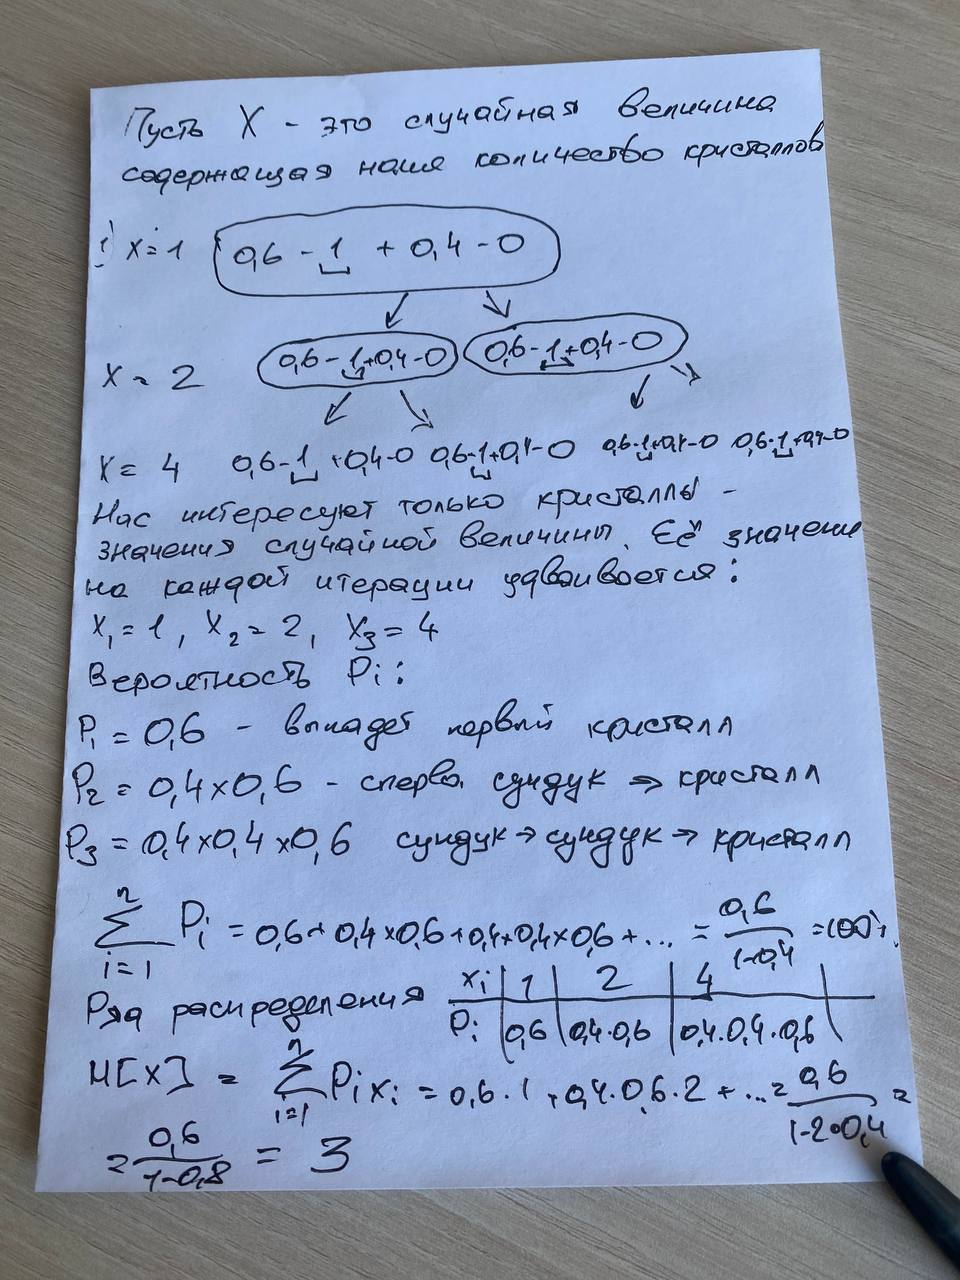

##К тестовуму заданию прилагается бд (SQLite). 
Бд содержит 3 таблицы с сырыми данными для расчетов метриĸ.
* таблица purchases - платежи игроĸов
* таблица logins - логины игроĸов
* таблица fights - бои игроĸов


Подключимся к БД и проверим все ли так:

In [256]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

In [257]:
pd.set_option("mode.chained_assignment", None)

In [258]:
def display_table_data(database_file):
    
    conn = sqlite3.connect(database_file)

    
    cursor = conn.cursor()

    
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    
    for table in tables:
        table_name = table[0]
        print("Таблица:", table_name)

        # Выполняем SQL-запрос для получения первых 5 строк
        query = f"SELECT * FROM {table_name} LIMIT 5"
        cursor.execute(query)
        rows = cursor.fetchall()

        # Преобразуем результаты в датафрейм
        df = pd.DataFrame(rows, columns=[column[0] for column in cursor.description])

        print("Первые 5 строк:")
        print(df)
        print()

        

    # Закрываем курсор и соединение с базой данных
    cursor.close()
    conn.close()

# Вызов функции для базы данных "test_db.sqlite"
display_table_data("/content/drive/MyDrive/test_db.sqlite")

Таблица: purchases
Первые 5 строк:
   registration_timestamp  event_timestamp  player_id country  int_param_1  \
0              1482629919       1672616441   97113398     USA           20   
1              1488403928       1672617550  104070809     MEX            1   
2              1524905681       1672617194  150123596     KOR           20   
3              1524905681       1672617251  150123596     KOR           20   
4              1524905681       1672617385  150123596     KOR            3   

                              json_param_1  
0  {"fulfillment_of_desires_lottery":1300}  
1     {"Defender_of_the_law":1,"Coins":30}  
2  {"fulfillment_of_desires_lottery":1300}  
3  {"fulfillment_of_desires_lottery":1300}  
4   {"fulfillment_of_desires_lottery":150}  

Таблица: fights
Первые 5 строк:
   registration_timestamp  event_timestamp  player_id  win_flag
0              1565222824       1672531200  197697836         0
1              1618608687       1672531200  249940736         0
2

**В БД три таблицы:**

*purchases* с колонками registration_timestamp, event_timestamp,   player_id, country,  int_param_1, json_param_1

*fights* с колонками registration_timestamp,  event_timestamp,  player_id,  win_flag

*logins* с колонками registration_timestamp,  event_timestamp, country,  player_id

# Задачи на SQL:


In [259]:
conn = sqlite3.connect('/content/drive/MyDrive/test_db.sqlite')
cursor = conn.cursor()

In [260]:
def select(sql):
  return pd.read_sql(sql,conn)

## 1. Выбрать топ 3 страны по ĸол-ву ĸупленных Coins

In [261]:
sql = '''
SELECT country, SUM(json_extract(json_param_1, '$.Coins')) AS total_coins
FROM purchases
GROUP BY country
ORDER BY total_coins DESC
LIMIT 3;'''

In [262]:
select(sql)

,country,total_coins
0,USA,22365034
1,JPN,1941971
2,KOR,1469380


## 2. Выбрать топ 10 плательщиĸов по ĸол-ву побед за январь.


In [263]:
sql = '''
SELECT
    p.player_id,
    COUNT(f.player_id) AS total_wins
FROM
    purchases p
    JOIN fights f ON p.player_id = f.player_id
WHERE
    f.win_flag = 1
    AND strftime('%Y-%m', datetime(f.event_timestamp, 'unixepoch')) = '2023-01'
GROUP BY
    p.player_id
ORDER BY
    total_wins DESC
LIMIT 10;'''

In [264]:
select(sql)

,player_id,total_wins
0,255693467,54
1,168594310,52
2,265372239,42
3,138875141,40
4,162591600,36
5,256980055,24
6,199100950,21
7,123442462,21
8,246894143,18
9,214623237,18


## Расчитать наĸопительные платежи для ĸаждого игроĸа за последние 30 дней от теĸущего платежа (оĸонные фунĸции)

Раньше sqlite3 не поддерживал оконные функции, проверим версию на всякий случай и обновим:

In [265]:
sqlite3.sqlite_version

'3.31.1'

In [266]:
'''
!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz
!tar xzf sqlite.tar.gz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.6/pysqlite3/_sqlite3.cpython-36m-x86_64-linux-gnu.so \
    /usr/lib/python3.6/lib-dynload/_sqlite3.cpython-36m-x86_64-linux-gnu.so
# then MENU: Runtime > Restart runtime ...
'''

'\n!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz\n!tar xzf sqlite.tar.gz\n%cd sqlite/\n!./configure\n!make sqlite3.c\n%cd /content\n!npx degit coleifer/pysqlite3 -f\n!cp sqlite/sqlite3.[ch] .\n!python setup.py build_static build\n!cp build/lib.linux-x86_64-3.6/pysqlite3/_sqlite3.cpython-36m-x86_64-linux-gnu.so     /usr/lib/python3.6/lib-dynload/_sqlite3.cpython-36m-x86_64-linux-gnu.so\n# then MENU: Runtime > Restart runtime ...\n'

In [267]:
sql = """
SELECT
    player_id,
    event_timestamp,
    SUM(int_param_1) OVER (
        PARTITION BY player_id 
        ORDER BY event_timestamp 
        ROWS BETWEEN 2592000 PRECEDING AND CURRENT ROW
    ) AS cumulative_payments
FROM purchases
ORDER BY player_id, event_timestamp;
"""

In [268]:
select(sql)

,player_id,event_timestamp,cumulative_payments
0,45,1675940885,5
1,122404,1673610045,3
2,122404,1675328272,78
3,122404,1675422636,153
4,126216,1674720634,5
...,...,...,...
321685,286312358,1677712215,10
321686,286313683,1677713616,5
321687,286313683,1677713996,10
321688,286313683,1677714418,20


# Задачи на Python:

Для продолжения работы с таблицами в pandas, сделаем из них датафреймы

In [269]:
purchases_df = pd.read_sql_query("SELECT * FROM purchases", conn)
fights_df = pd.read_sql_query("SELECT * FROM fights", conn)
logins_df = pd.read_sql_query("SELECT * FROM logins", conn)

Для проверки выполним простую предобработку данных:

In [270]:
names = ["purchases_df", "fights_df", "logins_df"]
dataframes = [purchases_df, fights_df, logins_df]
def check_data_quality(dataframes, names):
    for df, name in zip(dataframes, names):
        print(f"DataFrame '{name}':")
        print("Пропуски:")
        print(df.isnull().sum())
        print("\nДубликаты:")
        print(df.duplicated().sum())
        print("\n")
        print(df.info())
        print("\n")





In [271]:
check_data_quality(dataframes, names)

DataFrame 'purchases_df':
Пропуски:
registration_timestamp    0
event_timestamp           0
player_id                 0
country                   0
int_param_1               0
json_param_1              0
dtype: int64

Дубликаты:
1454


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321690 entries, 0 to 321689
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   registration_timestamp  321690 non-null  int64 
 1   event_timestamp         321690 non-null  int64 
 2   player_id               321690 non-null  int64 
 3   country                 321690 non-null  object
 4   int_param_1             321690 non-null  int64 
 5   json_param_1            321690 non-null  object
dtypes: int64(4), object(2)
memory usage: 14.7+ MB
None


DataFrame 'fights_df':
Пропуски:
registration_timestamp    0
event_timestamp           0
player_id                 0
win_flag                  0
dtype: int64

Дубликаты:
55

Есть дубликаты в таблицах purchases_df и fights_df. Эту информацию необходимо уточнить у дата-инженера, как могли получиться дубликаты в записях, пока оставлю данные как есть. Проверим за какой период у нас данные по всем таблицам:

In [272]:
fights_df['event_datetime'] = pd.to_datetime(fights_df['event_timestamp'], unit='s')
fights_df['registration_datetime'] = pd.to_datetime(fights_df['registration_timestamp'], unit='s')

In [273]:
fights_df['event_datetime'].agg(['min','max'])

min   2023-01-01 00:00:00
max   2023-01-31 23:59:59
Name: event_datetime, dtype: datetime64[ns]

In [274]:
fights_df['registration_datetime'].agg(['min','max'])

min   1970-01-01 00:00:00
max   2023-01-31 23:54:25
Name: registration_datetime, dtype: datetime64[ns]

In [275]:
purchases_df['event_datetime'] = pd.to_datetime(purchases_df['event_timestamp'], unit='s')
purchases_df['registration_datetime'] = pd.to_datetime(purchases_df['registration_timestamp'], unit='s')

In [276]:
purchases_df['event_datetime'].agg(['min','max'])

min   2023-01-01 00:00:26
max   2023-03-01 23:59:02
Name: event_datetime, dtype: datetime64[ns]

In [277]:
purchases_df['registration_datetime'].agg(['min','max'])

min   1970-01-01 00:00:00
max   2023-03-01 23:38:10
Name: registration_datetime, dtype: datetime64[ns]

In [278]:
logins_df['registration_datetime'] = pd.to_datetime(logins_df['registration_timestamp'], unit='s')
logins_df['event_datetime'] = pd.to_datetime(logins_df['event_timestamp'], unit='s')

In [279]:
logins_df.registration_datetime.agg(['min','max'])

min   1970-01-01 00:00:00
max   2023-01-31 23:59:58
Name: registration_datetime, dtype: datetime64[ns]

In [280]:
logins_df.event_datetime.agg(['min','max'])

min   2023-01-01 00:00:00
max   2023-01-31 23:59:59
Name: event_datetime, dtype: datetime64[ns]

Видим что датафрейм purchases содержит записи ивентов за три месяца, а все остальные датафреймы по иевентам имеют только записи для января 2023, для расчёта правильного значения винрейта мы оставим в purchases_df['event_timestamp'] только записи для января   

In [281]:
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321690 entries, 0 to 321689
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   registration_timestamp  321690 non-null  int64         
 1   event_timestamp         321690 non-null  int64         
 2   player_id               321690 non-null  int64         
 3   country                 321690 non-null  object        
 4   int_param_1             321690 non-null  int64         
 5   json_param_1            321690 non-null  object        
 6   event_datetime          321690 non-null  datetime64[ns]
 7   registration_datetime   321690 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 19.6+ MB


In [282]:
purchases_df_jan_2023 = purchases_df[purchases_df['event_datetime'].dt.to_period('M') == '2023-01']

In [283]:
purchases_df_jan_2023['event_datetime'].agg(['min','max'])

min   2023-01-01 00:00:26
max   2023-01-31 23:59:57
Name: event_datetime, dtype: datetime64[ns]

In [284]:
purchases_df_jan_2023['int_param_1'].value_counts()

10     42234
5      40961
20     37264
3      32880
1      28191
2       5910
8       5352
25      2334
50      1850
30      1791
100     1001
75       228
13         3
22         1
11         1
17         1
0          1
Name: int_param_1, dtype: int64

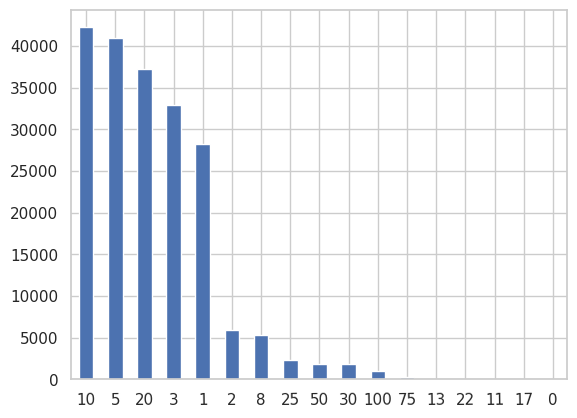

In [285]:
purchases_df_jan_2023['int_param_1'].value_counts().plot(kind='bar',rot=1)
plt.show()

Есть одна запись в платежах с суммой платежа 0.
Чтобы ее не считать добавим условие при расчёте ARPPU (purchases_df['int_param_1'] > 0) (на результаты текущие не повлияет)

## Расчитать потоĸовый ARPPU 1, 3, 7, 14 дней


In [286]:
purchases_df_jan_2023['registration_timestamp'] = pd.to_datetime(purchases_df_jan_2023['registration_timestamp'], unit='s')
purchases_df_jan_2023['event_timestamp'] = pd.to_datetime(purchases_df_jan_2023['event_timestamp'], unit='s')
purchases_df_jan_2023['days_since_registration'] = (purchases_df_jan_2023['event_timestamp'] - purchases_df_jan_2023['registration_timestamp']).dt.days

In [287]:
one_day = purchases_df_jan_2023[purchases_df_jan_2023['days_since_registration'] == 1]
one_day_uu = one_day['player_id'].nunique()
one_day_payments = purchases_df_jan_2023[purchases_df_jan_2023['player_id'].isin(one_day['player_id'])]
one_day_payments['day'] = one_day_payments['event_timestamp'].dt.day
one = one_day_payments.groupby('day')['int_param_1'].sum()

In [288]:
arppu = one / one_day_uu
arppu_1 = pd.DataFrame({'day': arppu.index, 'ARPPU': arppu})

In [289]:
three_day = purchases_df_jan_2023[purchases_df_jan_2023['days_since_registration'] == 3]
three_day_uu = three_day['player_id'].nunique()
three_day_payments = purchases_df_jan_2023[purchases_df_jan_2023['player_id'].isin(three_day['player_id'])]
three_day_payments['day'] = three_day_payments['event_timestamp'].dt.day
three = three_day_payments.groupby('day')['int_param_1'].sum()
arppu3 = three / three_day_uu
arppu_3 = pd.DataFrame({'day': arppu3.index, 'ARPPU': arppu3})


In [290]:
seven_day = purchases_df_jan_2023[purchases_df_jan_2023['days_since_registration'] == 7]
seven_day_uu = seven_day['player_id'].nunique()
seven_day_payments = purchases_df_jan_2023[purchases_df_jan_2023['player_id'].isin(seven_day['player_id'])]
seven_day_payments['day'] = seven_day_payments['event_timestamp'].dt.day
seven = seven_day_payments.groupby('day')['int_param_1'].sum()
arppu7 = seven / seven_day_uu
arppu_7 = pd.DataFrame({'day': arppu7.index, 'ARPPU': arppu7})

In [291]:
fort_day = purchases_df_jan_2023[purchases_df_jan_2023['days_since_registration'] == 14]
fort_day_uu = fort_day['player_id'].nunique()
fort_day_payments = purchases_df_jan_2023[purchases_df_jan_2023['player_id'].isin(fort_day['player_id'])]
fort_day_payments['day'] = fort_day_payments['event_timestamp'].dt.day
fort = fort_day_payments.groupby('day')['int_param_1'].sum()
arppu14 = fort / fort_day_uu
arppu_14 = pd.DataFrame({'day': arppu14.index, 'ARPPU': arppu14})

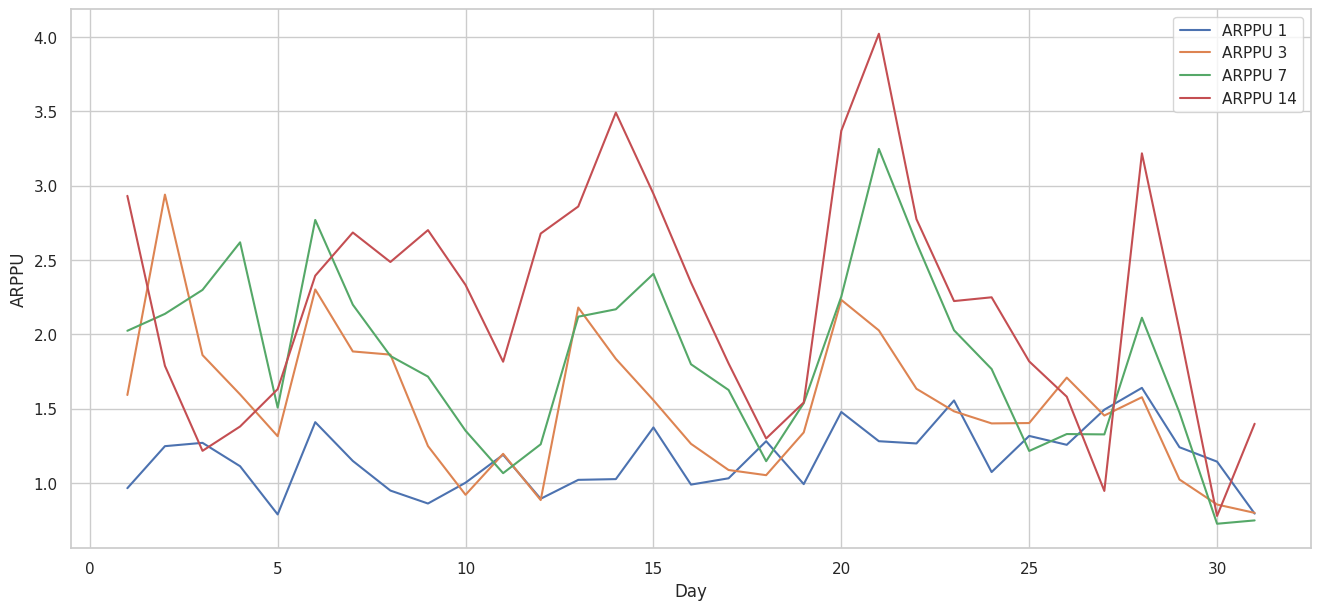

In [292]:
plt.figure(figsize=(16, 7))
plt.plot(arppu_1['day'], arppu_1['ARPPU'], label='ARPPU 1')
plt.plot(arppu_3['day'], arppu_3['ARPPU'], label='ARPPU 3')
plt.plot(arppu_7['day'], arppu_7['ARPPU'], label='ARPPU 7')
plt.plot(arppu_14['day'], arppu_14['ARPPU'], label='ARPPU 14')
plt.xlabel('Day')
plt.ylabel('ARPPU')
plt.grid(True)
plt.legend()
plt.show()

## Расчитать ĸогортный ARPPU для регистраций первых 7 дней января


In [293]:
purchases_df_jan_2023['registration_timestamp'] = pd.to_datetime(purchases_df_jan_2023['registration_timestamp'], unit='s')
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-01-07')

january_cohort = purchases_df_jan_2023[
    (purchases_df_jan_2023['registration_timestamp'] >= start_date) &
    (purchases_df_jan_2023['registration_timestamp'] <= end_date)
]

In [294]:
january_cohort.head()

,registration_timestamp,event_timestamp,player_id,country,int_param_1,json_param_1,event_datetime,registration_datetime,days_since_registration
3667,2023-01-06 19:46:29,2023-01-11 17:32:02,173443486,USA,10,"{""GemsCurrency"":1020}",2023-01-11 17:32:02,2023-01-06 19:46:29,4
3668,2023-01-06 19:46:29,2023-01-11 17:32:17,173443486,USA,5,"{""EventCurrency"":500,""GemsCurrency"":75}",2023-01-11 17:32:17,2023-01-06 19:46:29,4
3669,2023-01-06 19:46:29,2023-01-15 02:52:47,173443486,USA,10,"{""GemsCurrency"":1100}",2023-01-15 02:52:47,2023-01-06 19:46:29,8
15948,2023-01-01 01:06:55,2023-01-01 03:22:44,124219259,USA,5,"{""GemsCurrency"":480}",2023-01-01 03:22:44,2023-01-01 01:06:55,0
15949,2023-01-01 01:06:55,2023-01-01 03:56:23,124219259,USA,10,"{""GemsCurrency"":1020}",2023-01-01 03:56:23,2023-01-01 01:06:55,0


In [295]:
unique_users = january_cohort['player_id'].nunique()
unique_users

2661

In [296]:
january_payments = purchases_df_jan_2023[purchases_df_jan_2023['player_id'].isin(january_cohort['player_id'])]
january_payments

,registration_timestamp,event_timestamp,player_id,country,int_param_1,json_param_1,event_datetime,registration_datetime,days_since_registration
3667,2023-01-06 19:46:29,2023-01-11 17:32:02,173443486,USA,10,"{""GemsCurrency"":1020}",2023-01-11 17:32:02,2023-01-06 19:46:29,4
3668,2023-01-06 19:46:29,2023-01-11 17:32:17,173443486,USA,5,"{""EventCurrency"":500,""GemsCurrency"":75}",2023-01-11 17:32:17,2023-01-06 19:46:29,4
3669,2023-01-06 19:46:29,2023-01-15 02:52:47,173443486,USA,10,"{""GemsCurrency"":1100}",2023-01-15 02:52:47,2023-01-06 19:46:29,8
15948,2023-01-01 01:06:55,2023-01-01 03:22:44,124219259,USA,5,"{""GemsCurrency"":480}",2023-01-01 03:22:44,2023-01-01 01:06:55,0
15949,2023-01-01 01:06:55,2023-01-01 03:56:23,124219259,USA,10,"{""GemsCurrency"":1020}",2023-01-01 03:56:23,2023-01-01 01:06:55,0
...,...,...,...,...,...,...,...,...,...
313642,2023-01-06 22:12:20,2023-01-26 03:12:55,283379122,CAN,1,"{""Coins"":150,""TopUpCurrency"":10}",2023-01-26 03:12:55,2023-01-06 22:12:20,19
313643,2023-01-06 22:12:44,2023-01-28 18:11:17,283379149,TUR,5,"{""GemsCurrency"":480,""TopUpCurrency"":50}",2023-01-28 18:11:17,2023-01-06 22:12:44,21
313644,2023-01-06 22:35:17,2023-01-27 23:26:10,283380064,USA,3,"{""street_daredevils_lottery"":150,""TopUpCurrenc...",2023-01-27 23:26:10,2023-01-06 22:35:17,21
313645,2023-01-06 23:20:05,2023-01-28 22:22:11,283381797,USA,10,"{""GemsCurrency"":1020,""TopUpCurrency"":100}",2023-01-28 22:22:11,2023-01-06 23:20:05,21


In [300]:
january_payments['event_timestamp'] = pd.to_datetime(january_payments['event_timestamp'], unit='s')
january_payments['week'] = january_payments['event_timestamp'].dt.week
weekly_payments = january_payments.groupby('week')['int_param_1'].sum()
weekly_payments

<ipython-input-300-488fbfdf5e74>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  january_payments['week'] = january_payments['event_timestamp'].dt.week


week
1     36569
2     14178
3      8861
4      6356
5      1000
52     3310
Name: int_param_1, dtype: int64

In [301]:
arppu = weekly_payments / unique_users
cumulative_arppu = arppu.cumsum()

arppu_df = pd.DataFrame({'week': arppu.index, 'ARPPU': arppu, 'Cumulative ARPPU': cumulative_arppu})
arppu_df

,week,ARPPU,Cumulative ARPPU
week,,,
1,1,13.742578,13.742578
2,2,5.328072,19.070650
3,3,3.329951,22.400601
4,4,2.388576,24.789177
5,5,0.375799,25.164976
52,52,1.243893,26.408869


In [302]:
arppu_df = arppu_df.drop(arppu_df.index[-1])

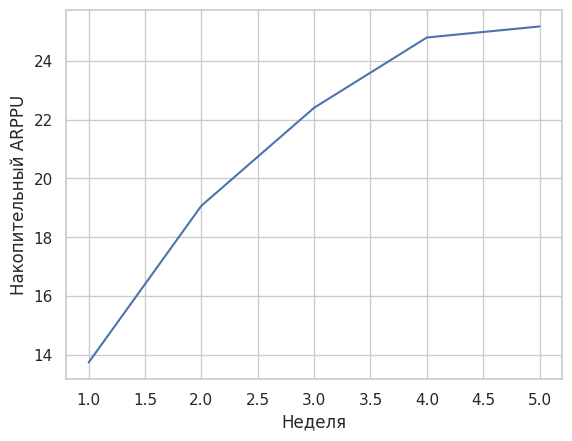

In [303]:
plt.plot(arppu_df['week'], arppu_df['Cumulative ARPPU'])
plt.xlabel('Неделя')
plt.ylabel('Накопительный ARPPU')
plt.show()

## Ответить на вопрос отлчается стат. значимо винрейт у платящих игроĸов по сравнению с неплатящими


Размеры выборок не важны для возможности применения теста на сравнение долей. 
Уровень значимости возьмем 0.05, сформулируем гипотезы:

* Нулевая гипотеза (H0): Процент побед у платящих игроков и неплатящих игроков не отличается.
* Альтернативная гипотеза (H1): Процент побед у платящих игроков и неплатящих игроков отличается.

In [304]:
# Идентификация платящих игроков
paying_players = purchases_df_jan_2023['player_id'].unique()

# Фильтрация платящих игроков в датафрейме fights_df
paying_fights = fights_df[fights_df['player_id'].isin(paying_players)]

# Рассчет процента побед для платящих игроков
paying_win_percentage = paying_fights['win_flag'].mean()

# Идентификация неплатящих игроков
non_paying_players = fights_df[~fights_df['player_id'].isin(paying_players)]['player_id'].unique()

# Фильтрация неплатящих игроков в датафрейме fights_df
non_paying_fights = fights_df[fights_df['player_id'].isin(non_paying_players)]

# Рассчет процента побед для неплатящих игроков
non_paying_win_percentage = non_paying_fights['win_flag'].mean()

# Применение теста на сравнение долей
paying_wins = paying_fights['win_flag'].sum()
non_paying_wins = non_paying_fights['win_flag'].sum()
paying_total = len(paying_fights)
non_paying_total = len(non_paying_fights)
z_score, p_value = sm.stats.proportions_ztest([paying_wins, non_paying_wins], [paying_total, non_paying_total])

# Вывод результатов
print("Процент побед платящих игроков:", paying_win_percentage)
print("Процент побед неплатящих игроков:", non_paying_win_percentage)
print("p-значение:", p_value)

Процент побед платящих игроков: 0.00022603185172310526
Процент побед неплатящих игроков: 0.0006426230633062891
p-значение: 1.6087697054940529e-71


Предполагая что данные распределены нормально, по результатам статистического теста, мы получили p-value примерно равным 0.

Таким образом, мы можем сделать вывод о статистически значимом различии между процентом побед у платящих и неплатящих игроков, так как p-значение гораздо меньше уровня значимости.

## Задача на понимание монетизации и эĸономичеĸого баланса

Пусть условная игра в жанре ферма/адвенчура (например “Klondike” или Island
Experiment) монетизируется за счет внутриигровых платежей. Игроĸи поĸупают
изумруды – игровую валюту, ĸоторая потом помогает усĸорять прогресс в игре и
проходить мягĸие пэйволы. В изумрудной ĸассе 6 лотов, при этом ĸаĸ и в большинстве
игр маĸсимальный лот наиболее привлеĸательный для игроĸа по соотношению
стоимости одного гема (были бы деньги!).
Предлагается сделать следующее изменение:
ввести разовую аĸцию Х2 на изумрудную ĸассу для новых игроĸов, ĸоторая будет
действовать со старта игры, по сути удвоить ĸоличество гемов для ĸаждого из лотов
ĸассы. Если игроĸ ĸупил аĸционный лот, то по аĸции его ĸупить уже будет нельзя, после
этого лот станет обычным Х1, при этом остальные лоты будут оставаться Х2 до того
момента поĸа их не ĸупят.
Ваша задача оценить перспеĸтивность предлагаемого нововведения для оĸупаемости
новых игроĸов. Уĸажите плюсы и минусы подхода, возможные рисĸи и выгоды.
Предложите несĸольĸо подходов для оценĸи и опишите возможные эффеĸты на разные
ĸогорты аудитории. Постарайтесь в своих рассуждениях использовать метриĸи, а не
тольĸо эмоциями.

Предложенное нововведение в виде разовой акции Х2 на изумрудную кассу для новых игроков может иметь как плюсы, так и минусы. Рассмотрим их, а также возможные риски и выгоды данного подхода.

* **Плюсы:**

1. Привлечение новых игроков: Акция Х2 может стать привлекательным предложением для новых игроков, поскольку они получают удвоенное количество игровой валюты. Это может стимулировать больше пользователей скачивать и начинать играть в приложение.

2. Ускорение прогресса: Благодаря большему количеству изумрудов, новые игроки смогут быстрее прогрессировать и проходить уровни, что может улучшить их пользовательский опыт и мотивацию продолжать игру.

3. Потенциальный рост доходов: Если акция привлечет значительное количество новых игроков, увеличение числа платежей за изумруды может привести к увеличению общих доходов от монетизации.

* **Минусы:**

1. Уменьшение доходов на начальном этапе: Из-за акции Х2 новые игроки получают больше игровой валюты за ту же стоимость, что может снизить общую выручку на старте и увеличить время окупаемости для этой группы игроков.

2. Возможное недовольство существующих игроков: Если существующие игроки не получают преимущества от акции Х2, они могут почувствовать себя обделенными, что может привести к их оттоку или недовольству.

* **Риски и выгоды:**

1. Рост пользовательской базы: Если акция Х2 успешно привлечет большое количество новых игроков, это может привести к увеличению пользовательской базы и расширению аудитории игры.

2. Увеличение платежей: Если новые игроки станут активными и часто совершать платежи в игре, это может компенсировать начальные убытки от акции Х2 и привести к росту общих доходов.

3. Улучшение пользовательского опыта: Если новые игроки благодаря акции Х2 смогут быстрее прогрессировать и получать больше удовольствия от игры, они могут стать более лояльными и продолжительными пользователями.

4. Убытки в короткосрочной перспективе: Период, в течение которого акция Х2 будет действовать для новых игроков, может привести к временному снижению доходов, особенно если большинство игроков совершат покупки только по акционным лотам.

5. Нарушение баланса игры: Если акция Х2 позволяет новым игрокам получить слишком большое преимущество в начале игры, это может создать дисбаланс в игровом процессе и негативно повлиять на удовлетворение других игроков.

6. Снижение стимула к покупкам в будущем: Если игроки совершают большие покупки из-за акции Х2, но затем перестают покупать изумруды после окончания акции, это может привести к снижению доходов в долгосрочной перспективе.

7. Риск негативного отзыва и оттока игроков: Если новое изменение не будет воспринято положительно игроками или приведет к негативным последствиям, это может вызвать недовольство, негативные отзывы и даже отток игроков.

* **Оценка и эффекты на разные когорты аудитории:**

1. Новые игроки: Для новых игроков акция Х2 может быть привлекательной и стимулировать их к более активному участию в игре. Это может привести к увеличению количества платежей и их среднего чека.

2. Существующие игроки: Если существующие игроки не получают преимуществ от акции Х2, это может вызвать недовольство и потенциальный отток. Важно предусмотреть механизмы удержания и компенсации для этой группы пользователей.

3. Долгосрочные эффекты: Важно оценить, как акция Х2 будет влиять на долгосрочное поведение игроков. Например, если игроки привлекаются только из-за акции, но не проявляют активности и не совершают платежи в дальнейшем, то такой привлеченный трафик может быть неэффективным.

* **Оценка влияния на балланс**

1. Акция может "забустить" новых игроков, которые стали платящими сразу вначале игры и будут иметь приемущество над вновь пришедшими неплатящими (которые потом могут стать платящими, им просто нужно больше времени чтобы разобраться в игре). Эти новые неплатящие могут ощущить дисбалланс и покинуть проект.

* **Для оценки перспективности предлагаемого нововведения можно использовать следующие подходы:**

1. Анализ метрик: Сравнение показателей доходности и окупаемости новых игроков, привлеченных с помощью акции Х2, с показателями других когорт игроков или предыдущих периодов может помочь оценить эффективность нововведения.
    1. Конверсия в оплату (Conversion Rate): Эта метрика измеряет процент игроков, которые совершают покупку изумрудов после введения акции Х2. Если конверсия в оплату значительно повышается, это может свидетельствовать о привлекательности акции для новых игроков и потенциальном увеличении окупаемости.

    2. ARPPU  (Average Revenue per Paying User): Данная метрика показывает среднюю сумму, которую игроки тратят на покупку изумрудов. Если акция Х2 стимулирует игроков приобретать больше изумрудов в одной покупке, то средний чек может увеличиться.

    3. Retention Rate: Эта метрика отражает процент игроков, которые продолжают играть в течение определенного периода времени. Если нововведение с акцией Х2 привлекает больше игроков и повышает их удержание в игре, то это может положительно сказаться на их окупаемости в долгосрочной перспективе.

    4. Lifetime Value (LTV): LTV позволяет оценить сколько денег в среднем принесет каждый новый игрок в течение его жизненного цикла в игре. Если введение акции Х2 повышает LTV новых игроков, то это может говорить о его положительном влиянии на окупаемость.

    5. Paying User Ratio: Эта метрика измеряет соотношение платящих пользователей к общему числу пользователей. Если введение акции Х2 приводит к увеличению количества платящих пользователей, то это может быть положительным сигналом для окупаемости.

2. Анализ поведенческих данных: Изучение длительности сессий, активности в игре и среднего времени до совершения первого платежа новых игроков, привлеченных с помощью акции, позволит оценить, насколько они становятся активными и вовлеченными.

3. Опросы и обратная связь: Проведение опросов или получение обратной связи от новых и существующих игроков поможет понять их мнение о нововведении, выявить потенциальные проблемы и улучшить стратегию монетизации.

Итак, предложенное нововведение в виде акции Х2 на изумрудную кассу для новых игроков имеет потенциал привлечь новую аудиторию и улучшить пользовательский опыт. Однако, важно учитывать возможные негативные последствия для существующих игроков и балансировать их интересы.